# Base d'apprentissage et de test

Le modèle est estimé sur une base d'apprentissage et évalué sur une base de test.

In [2]:
%matplotlib inline

In [3]:
from teachpyx.datasets import load_wines_dataset

df = load_wines_dataset()
X = df.drop(["quality", "color"], axis=1)
y = df["quality"]

On divise en base d'apprentissage et de test avec la fonction [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

In [6]:
prediction = knn.predict(X_test)

In [7]:
import pandas

res = pandas.DataFrame(dict(expected=y_test, prediction=prediction))
res.head()

,expected,prediction
2763,6,5.0
4504,5,6.0
1063,6,7.0
2238,5,5.0
6118,6,6.0


/home/xadupre/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xadupre/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xadupre/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xadupre/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

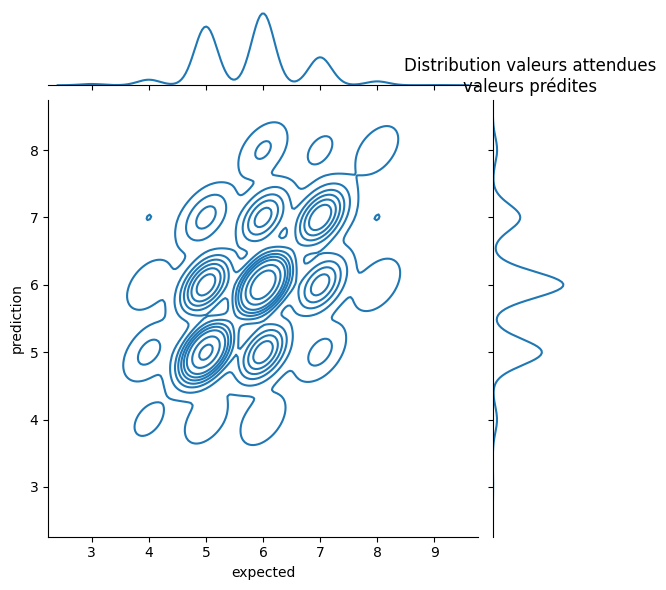

In [11]:
from seaborn import jointplot

ax = jointplot(res, x="expected", y="prediction", kind="kde")
ax.ax_marg_y.set_title("Distribution valeurs attendues\nvaleurs prédites");

Le résultat paraît acceptable. On enlève les réponses correctes.

/home/xadupre/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xadupre/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xadupre/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xadupre/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

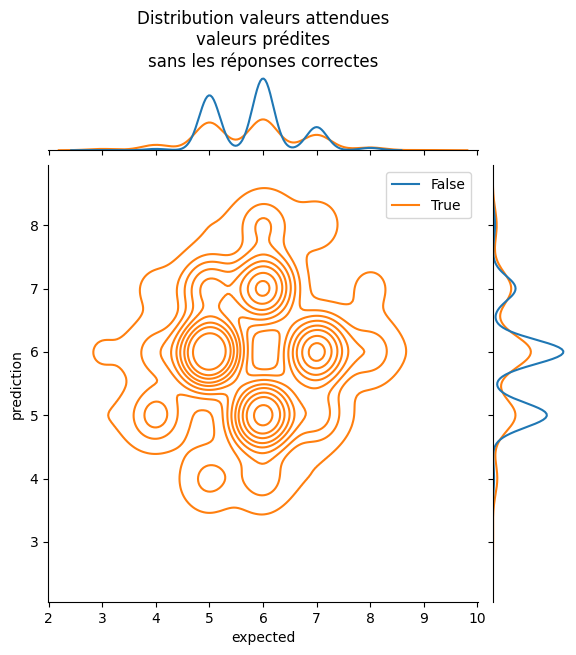

In [14]:
ax = jointplot(
    res,
    x="expected",
    y="prediction",
    hue=res["expected"] != res["prediction"],
    kind="kde",
)
ax.ax_marg_x.set_title(
    "Distribution valeurs attendues\nvaleurs prédites\n" "sans les réponses correctes"
);

In [15]:
res["diff"] = res["prediction"] - res["expected"]

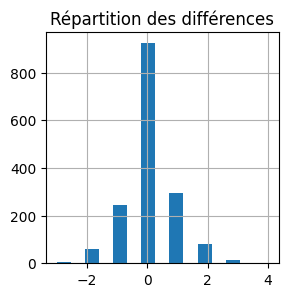

In [16]:
ax = res["diff"].hist(bins=15, figsize=(3, 3))
ax.set_title("Répartition des différences");

Si on fait la moyenne des erreurs en valeur absolue :

In [17]:
import numpy

numpy.abs(res["diff"]).mean()

0.5452307692307692

Le modèle se trompe en moyenne d'un demi point. Le module *scikit-learn* propose de nombreuses [métriques](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) pour évaluer les résultats. On s'intéresse plus particulièrement à celle de la [régression](http://scikit-learn.org/stable/modules/classes.html#regression-metrics). Celle qu'on a utilisée s'appelle [mean_absolute_error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error).

In [18]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, prediction)

0.5452307692307692

Un autre indicateur très utilisé : [R2](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score).

In [19]:
from sklearn.metrics import r2_score

r2_score(y_test, prediction)

-0.052827181324763384

Une valeur négative implique que le modèle fait moins bien que si la prédiction était constante et égale à la moyenne des notes sur la base de test. Essayons.

In [20]:
const = numpy.mean(y_test) * numpy.ones(y_test.shape[0])
r2_score(y_test, const)

0.0

Pour être rigoureux, il faudrait prendre la moyenne des notes sur la base d'apprentissage, celles des vins connus.

In [21]:
const = numpy.mean(y_train) * numpy.ones(y_test.shape[0])
r2_score(y_test, const)

-0.0033815067443303537

Sensiblement pareil et on sait maintenant que le modèle n'est pas bon. On cherche une explication. Une raison possible est que les bases d'apprentissage et de test ne sont pas homogènes : le modèle apprend sur des données et est testé sur d'autres qui n'ont rien à voir. On commence par regarder la distribution des notes.

In [24]:
ys = pandas.DataFrame(dict(y=y_train))
ys["base"] = "train"
ys2 = pandas.DataFrame(dict(y=y_test))
ys2["base"] = "test"
ys = pandas.concat([ys, ys2])
ys["compte"] = 1
piv = (
    ys.groupby(["base", "y"], as_index=False)
    .count()
    .pivot(index="y", columns="base", values="compte")
)
piv["ratio"] = piv["test"] / piv["train"]
piv

base,test,train,ratio
y,,,
3,12,18,0.666667
4,53,163,0.325153
5,563,1575,0.357460
6,690,2146,0.321528
7,268,811,0.330456
8,37,156,0.237179
9,2,3,0.666667


On voit le ratio entre les deux classes est à peu près égal à 1/3 sauf pour les notes sous-représentées. On voit également que les classes 5,6,7 sont sur-représentées. Autrement dit, si je choisis un vin au hasard, il y a 90% de chance que sa note soit 5, 6 ou 7.